In [25]:
import requests
import json
import codecs

import pandas as pd
import numpy as np
import pyautogui as pg

from math import radians
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import haversine_distances

import warnings
warnings.filterwarnings('ignore')

In [26]:
def immoscout24parser(html):
        
    try:
        soup = BeautifulSoup(html, 'html.parser')
        scripts = soup.findAll('script')
        for script in scripts:
            #print script.text.strip()
            if 'IS24.resultList' in script.text.strip():
                s = script.string.split('\n')
                for line in s:
                    #print('\n\n\'%s\'' % line)
                    if line.strip().startswith('resultListModel'):
                        resultListModel = line.strip('resultListModel: ')
                        immo_json = json.loads(resultListModel[:-1])

                        searchResponseModel = immo_json[u'searchResponseModel']
                        resultlist_json = searchResponseModel[u'resultlist.resultlist']
                        
                        return resultlist_json

    except Exception as e:
        print("Fehler in immoscout24 parser: %s" % e)

In [200]:
immos = {}

def convert_html_str_to_dict(html_str):
    b = 'Berlin' # Bundesland
    s = 'Berlin' # Stadt
    k = 'Wohnung' # Wohnung oder Haus
    w = 'miete' # Miete oder Kauf



    resultlist_json = immoscout24parser(html_str)
    numberOfPages = int(resultlist_json[u'paging'][u'numberOfPages'])
    pageNumber = int(resultlist_json[u'paging'][u'pageNumber'])


    # Get the data
    for resultlistEntry in resultlist_json['resultlistEntries'][0][u'resultlistEntry']:

        realEstate = {}

        try:
            realEstate['distance'] = resultlistEntry['distance']
        except:
            realEstate['distance'] = None

        try:
            realEstateTags = resultlistEntry['realEstateTags']
            tags = realEstateTags['tag']
            if type(tags) == list:
                realEstate['realEstateTags'] = tags
            else:
                realEstate['realEstateTags'] = [tags]
        except:
            realEstate['realEstateTags'] = list([])


        realEstate_json = resultlistEntry[u'resultlist.realEstate']
        realEstate[u'Miete/Kauf'] = w
        realEstate[u'Haus/Wohnung'] = k
        realEstate['address'] = realEstate_json['address']['description']['text']
        realEstate['city'] = realEstate_json['address']['city']
        realEstate['postcode'] = int(realEstate_json['address']['postcode'])
        realEstate['quarter'] = realEstate_json['address']['quarter']
        realEstate['city'] = s

        try:
            realEstate['lat'] = float(realEstate_json['address'][u'wgs84Coordinate']['latitude'])
            realEstate['lon'] = float(realEstate_json['address'][u'wgs84Coordinate']['longitude'])
        except:
            realEstate['lat'] = None
            realEstate['lon'] = None

        try:
            realEstate['realtorCompanyName'] = realEstate_json['realtorCompanyName']
        except:
            realEstate['realtorCompanyName'] = None
    
        realEstate['title'] = realEstate_json['title']
        realEstate['numberOfRooms'] = int(realEstate_json['numberOfRooms'])
        realEstate['livingSpace'] = int(realEstate_json['livingSpace'])

        if k=='Wohnung':
            realEstate['balcony'] = realEstate_json['balcony']
            realEstate['builtInKitchen'] = realEstate_json['builtInKitchen']
            realEstate['garden'] = realEstate_json['garden']
            realEstate['privateOffer'] = (realEstate_json['privateOffer'] == 'true')
            realEstate['totalprice'] = float(realEstate_json['calculatedTotalRent']['totalRent']['value'])
        elif k=='Haus':
            realEstate['isBarrierFree'] = realEstate_json['isBarrierFree']
            realEstate['cellar'] = realEstate_json['cellar']
            realEstate['plotArea'] = realEstate_json['plotArea']
            realEstate['price'] = realEstate_json['price']['value']
            realEstate['privateOffer'] = realEstate_json['privateOffer']
            realEstate['energyPerformanceCertificate'] = realEstate_json['energyPerformanceCertificate']
        
        realEstate['floorplan'] = realEstate_json['floorplan']
        realEstate['from'] = realEstate_json['companyWideCustomerId']
        realEstate['ID'] = realEstate_json[u'@id']
        realEstate['url'] = u'https://www.immobilienscout24.de/expose/%s' % realEstate['ID']

        immos[realEstate['ID']] = realEstate
        

In [99]:
pg.PAUSE = 2.5
def scrape_save_page(url):
    input_x, input_y = 264, 64
    copy_x, copy_y = 21, 130
    data_x, data_y = 970, 985
    tab_x, tab_y = 231, 22

    pg.moveTo(input_x,input_y)
    pg.click(button="left")
    pg.typewrite(url)
    pg.typewrite(["enter"])

    pg.moveTo(copy_x,copy_y)
    pg.hotkey('ctrl', 'u') 
    pg.hotkey('ctrl', 'a')
    pg.hotkey('ctrl', 'c') 
    
    pg.moveTo(data_x, data_y)
    pg.click(button="left")
    pg.hotkey('ctrl', 'v')

    pg.moveTo(tab_x, tab_y)
    pg.click(button="left")

In [100]:
pages = [num for num in range(2,67)]
for page in pages:
  url=f"https://www.immobilienscout24.de/Suche/radius/wohnung-mieten?centerofsearchaddress=Berlin;;;1276003001;Berlin;&price=-3.0E10&livingspace=1.0-&exclusioncriteria=swapflat&pricetype=rentpermonth&geocoordinates=52.52343;13.41144;50.0&sorting=2&pagenumber={page}"
  #print(url)
  scrape_save_page(url)

KeyboardInterrupt: 

In [164]:
data_path = "rent_berlin_50_all.txt"
with open(data_path, encoding='utf-8') as file:
    data = file.read()
htmls = data.split('<!doctype html>')
htmls = htmls[1:]
htmls = ['<!doctype html>' + html for html in htmls]

In [212]:
for html_str in htmls:
    convert_html_str_to_dict(html_str)

df = pd.DataFrame(immos).T
df.index.name = 'ID'
for col in ['numberOfRooms', 'livingSpace', 'totalprice', 'distance']:
    df[col] = pd.to_numeric(df[col])
df['price_pro_quadratmeter'] = df['totalprice']/df['livingSpace']
df = df.loc[df.price_pro_quadratmeter < 200]

# tags = df['realEstateTags'].tolist()
# tags = set([tag for tag_list in tags for tag in tag_list])
tags = ['Aufzug','Balkon/Terrasse','Einbauküche','Garten','Gäste-WC','Keller','Stufenlos','WG-geeignet']
for tag in tags:
    df[tag] = df['realEstateTags'].apply(lambda x: tag in x)

In [214]:
df.columns

Index(['distance', 'realEstateTags', 'Miete/Kauf', 'Haus/Wohnung', 'address',
       'city', 'postcode', 'quarter', 'lat', 'lon', 'realtorCompanyName',
       'title', 'numberOfRooms', 'livingSpace', 'balcony', 'builtInKitchen',
       'garden', 'privateOffer', 'totalprice', 'floorplan', 'from', 'ID',
       'url', 'price_pro_quadratmeter', 'Aufzug', 'Balkon/Terrasse',
       'Einbauküche', 'Garten', 'Gäste-WC', 'Keller', 'Stufenlos',
       'WG-geeignet'],
      dtype='object')

In [224]:
cols_feature = ['postcode', 'Aufzug', 'Balkon/Terrasse',
       'Einbauküche', 'Garten', 'Gäste-WC', 'Keller', 'Stufenlos',
       'WG-geeignet', 'privateOffer']
       
cols_target = ['price_pro_quadratmeter']

Coefficients: 
 [[-2.02533446e-03  2.46367034e+00 -2.02098815e+00  4.59469062e+00
   1.71829025e+00  5.60096043e-01 -1.24626095e+00 -2.35025406e-01
  -1.92703264e+00 -2.18832377e+00]]
Mean squared error: 82.93
Coefficient of determination: 0.26


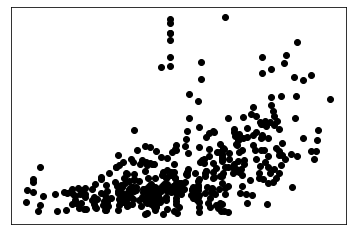

In [227]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
X, y = df[cols_feature], df[cols_target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test, color="black")

plt.xticks(())
plt.yticks(())

plt.show()
['postcode', 'Aufzug', 'Balkon/Terrasse',
       'Einbauküche', 'Garten', 'Gäste-WC', 'Keller', 'Stufenlos',
       'WG-geeignet', 'privateOffer']

In [235]:
X_test['y_pred'] = y_pred
X_test['y_test'] = y_test
pd.set_option('display.max_rows', 500)